### Cross-Validation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import calendar
import pickle
import time

%matplotlib inline
plt.style.use('seaborn-pastel')

import seaborn as sns
sns.set(style="whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from collections import defaultdict, Counter

%run evaluation_functions.py

In [2]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, 
                              AdaBoostClassifier, BaggingRegressor)


Using TensorFlow backend.
/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
with open('pickles/appt.pickle','rb') as read_file:
    appt = pickle.load(read_file)
with open('pickles/appt_v2.pickle','rb') as read_file:
    appt_v2 = pickle.load(read_file)
with open('pickles/appt_v2_all0.pickle','rb') as read_file:
    appt_v3 = pickle.load(read_file)
with open('pickles/appt_v2_all0.pickle','rb') as read_file:
    appt_v4 = pickle.load(read_file)

In [4]:
#Set features
# run for appt - all appts, basic features
feature_cols = ['Gender','Age','Scholarship','Hipertension','Diabetes','Alcoholism','Handcap','SMS_received',
                'ApptDayofWeek','SchedDayofWeek','Neighbourhood','DayDiff']
a_Xv1 = appt[feature_cols]
a_Xv1 = pd.get_dummies(a_Xv1, columns = ['Gender','Neighbourhood','ApptDayofWeek','SchedDayofWeek'])
a_Xv1.drop(columns=['Gender_F','Neighbourhood_VILA RUBIM','SchedDayofWeek_Monday','ApptDayofWeek_Monday'],inplace=True)
Xv1_cols = np.array(a_Xv1.columns)
a_Xv1.info()

## run for appt_v2 - second or more appts, adds historical features
feature_cols = ['Gender','Age2','Neighbourhood2','Scholarship','Hipertension','Diabetes','Alcoholism',
                'Handcap_bin','SMS_received','SchedDayofWeek','ApptDayofWeek','DayDiff2',
                'no_show_rate2','Reschedule','Follow_up']
a_Xv2 = appt_v2[feature_cols]
a_Xv2 = pd.get_dummies(a_Xv2, columns = ['Gender','Neighbourhood2','SchedDayofWeek','ApptDayofWeek'])
a_Xv2.drop(columns=['Gender_F','Neighbourhood2_OTHER','SchedDayofWeek_Monday','ApptDayofWeek_Monday'],inplace=True)
Xv2_cols = np.array(a_Xv2.columns)
a_Xv2.info()
# a_X.head(5)

## run for appt_v2_all0 - all appts, replaces no-show-rate NA's as 0's
feature_cols = ['Gender','Age2','Neighbourhood2','Scholarship','Hipertension','Diabetes','Alcoholism',
                'Handcap_bin','SMS_received','SchedDayofWeek','ApptDayofWeek','DayDiff2',
                'no_show_rate2','Reschedule','Follow_up']
a_Xv3 = appt_v3[feature_cols]
a_Xv3 = pd.get_dummies(a_Xv3, columns = ['Gender','Neighbourhood2','SchedDayofWeek','ApptDayofWeek'])
a_Xv3.drop(columns=['Gender_F','Neighbourhood2_OTHER','SchedDayofWeek_Monday','ApptDayofWeek_Monday'],inplace=True)
Xv3_cols = np.array(a_Xv3.columns)
a_Xv3.info()

## run for appt_v2_all0 - all appts, replaces no-show-rate NA's as imputed from linreg's
## run for appt_v2_all0 - all appts, uses prior_appt_count and prior_no_show_count
feature_cols = ['Gender','Age2','Neighbourhood2','Scholarship','Hipertension','Diabetes','Alcoholism',
                'Handcap_bin','SMS_received','SchedDayofWeek','ApptDayofWeek','DayDiff2',
                'Reschedule','Follow_up','prior_appt_count','prior_no_show_count']
a_Xv4 = appt_v4[feature_cols]
a_Xv4 = pd.get_dummies(a_Xv4, columns = ['Gender','Neighbourhood2','SchedDayofWeek','ApptDayofWeek'])
a_Xv4.drop(columns=['Gender_F','Neighbourhood2_OTHER','SchedDayofWeek_Monday','ApptDayofWeek_Monday'],inplace=True)
Xv4_cols = np.array(a_Xv4.columns)
a_Xv4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71163 entries, 0 to 71958
Data columns (total 97 columns):
Age                                          71163 non-null int64
Scholarship                                  71163 non-null int64
Hipertension                                 71163 non-null int64
Diabetes                                     71163 non-null int64
Alcoholism                                   71163 non-null int64
Handcap                                      71163 non-null int64
SMS_received                                 71163 non-null int64
DayDiff                                      71163 non-null int64
Gender_M                                     71163 non-null uint8
Neighbourhood_AEROPORTO                      71163 non-null uint8
Neighbourhood_ANDORINHAS                     71163 non-null uint8
Neighbourhood_ANTÔNIO HONÓRIO                71163 non-null uint8
Neighbourhood_ARIOVALDO FAVALESSA            71163 non-null uint8
Neighbourhood_BARRO VERMELHO     

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71163 entries, 65088 to 68006
Data columns (total 85 columns):
Age2                                  71163 non-null int64
Scholarship                           71163 non-null int64
Hipertension                          71163 non-null int64
Diabetes                              71163 non-null int64
Alcoholism                            71163 non-null int64
Handcap_bin                           71163 non-null int64
SMS_received                          71163 non-null int64
DayDiff2                              71163 non-null int64
no_show_rate2                         71163 non-null float64
Reschedule                            71163 non-null int64
Follow_up                             71163 non-null int64
Gender_M                              71163 non-null uint8
Neighbourhood2_ANDORINHAS             71163 non-null uint8
Neighbourhood2_BARRO VERMELHO         71163 non-null uint8
Neighbourhood2_BELA VISTA             71163 non-null uint8


In [5]:
#appt
Xv1, yv1 = a_Xv1, appt['No_show_num']
Xv1_train, Xv1_test, yv1_train, yv1_test = train_test_split(Xv1, yv1, test_size = 0.25, random_state = 10, stratify = yv1)
#appt_v2
Xv2, yv2 = a_Xv2, appt_v2['No_show_num']
Xv2_train, Xv2_test, yv2_train, yv2_test = train_test_split(Xv2, yv2, test_size = 0.25, random_state = 10, stratify = yv2)
#appt_v3
Xv3, yv3 = a_Xv3, appt_v3['No_show_num']
Xv3_train, Xv3_test, yv3_train, yv3_test = train_test_split(Xv3, yv3, test_size = 0.25, random_state = 10, stratify = yv3)
#appt_v4
Xv4, yv4 = a_Xv4, appt_v4['No_show_num']
Xv4_train, Xv4_test, yv4_train, yv4_test = train_test_split(Xv4, yv4, test_size = 0.25, random_state = 10, stratify = yv4)

In [6]:
#appt_v4
Xv4, yv4 = a_Xv4, appt_v4['No_show_num']
Xv4_train, Xv4_test, yv4_train, yv4_test = train_test_split(Xv4, yv4, test_size = 0.25, random_state = 10, stratify = yv4)

### Grid Search investigation

In [8]:
kf = StratifiedKFold(n_splits=5,random_state=60,shuffle=True)

#### Logistic Regression

In [9]:
model = Pipeline([
        ('sampling', RandomOverSampler(random_state=42)),
        ('class', LogisticRegression())
    ])

grid_params ={'class__penalty':['l1','l2'],
              'class__max_iter':[100,200,300,500],
              'class__solver':['liblinear','saga']}

In [10]:
def lrgs(X_train,y_train,X_test,y_test,version):
    start = time.time()
    
    LR_GS=GridSearchCV(model,grid_params,cv=kf,n_jobs=-1,verbose=1,scoring='roc_auc')
    LR_GS.fit(X_train,y_train)
    y_test_LR_GS_o = LR_GS.predict(X_test)
    y_test_LR_GS_o_prob = LR_GS.predict_proba(X_test)[:,1]
    print_scores(y_test,y_test_LR_GS_o)
    print(f'LR {version}: {roc_auc_score(y_test, y_test_LR_GS_o_prob):.3f}') # LR
    print(LR_GS.best_params_)
    end = time.time()
    print('minutes:',(end-start)/60)
    
    return

In [11]:
lrgs(Xv4_train,yv4_train,Xv4_test,yv4_test,'v4')

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  7.6min finished


Accuracy score: 0.5886684278567815
F1 score: 0.44026311763806025
Precision (true + / all predicted +): 0.35787117632429744
Recall (true + / all actual +): 0.571939586645469
LR v4: 0.617
{'class__max_iter': 100, 'class__penalty': 'l1', 'class__solver': 'saga'}
minutes: 7.95151309967041


/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


#### Random Forests

In [12]:
model = Pipeline([
        ('sampling', RandomOverSampler(random_state=42)),
        ('class', RandomForestClassifier(random_state=88))
    ])
grid_params = {'class__n_estimators':[500,1000,1500,2000],
               'class__max_depth':list(range(2,5)),
               'class__min_samples_leaf':list(range(2,5))}

In [13]:
def rfgs(X_train,y_train,X_test,y_test,version):
    start = time.time()
    
    RF_GS=GridSearchCV(model,grid_params,cv=kf,n_jobs=-1,verbose=1,scoring='roc_auc')
    RF_GS.fit(X_train,y_train)
    y_test_RF_GS_o = RF_GS.predict(X_test)
    y_test_RF_GS_o_prob = RF_GS.predict_proba(X_test)[:,1]
    print_scores(y_test,y_test_RF_GS_o)
    print(f'RF {version}: {roc_auc_score(y_test, y_test_RF_GS_o_prob):.3f}') # LR
    print(RF_GS.best_params_)
    end = time.time()
    print('minutes:',(end-start)/60)
    
    return

In [15]:
rfgs(Xv4_train,yv4_train,Xv4_test,yv4_test,'v4')

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 63.5min finished


Accuracy score: 0.594626496543196
F1 score: 0.4379675810473815
Precision (true + / all predicted +): 0.36025641025641025
Recall (true + / all actual +): 0.5584260731319555
RF v4: 0.621
{'class__max_depth': 4, 'class__min_samples_leaf': 2, 'class__n_estimators': 500}
minutes: 63.87662758032481


#### XGBoost

In [16]:
model = Pipeline([
        ('sampling', RandomOverSampler(random_state=42)),
        ('class', XGBClassifier(random_state=43))
    ])
grid_params = {'class__n_estimators':[500,1000],
               'class__max_depth':list(range(2,5))}

In [17]:
def xgbgs(X_train,y_train,X_test,y_test,version):
    start = time.time()
    
    XGB_GS=GridSearchCV(model,grid_params,cv=kf,n_jobs=-1,verbose=1,scoring='recall')
    XGB_GS.fit(X_train.values,y_train)
    y_test_XGB_GS_o = XGB_GS.predict(X_test.values)
    y_test_XGB_GS_o_prob = XGB_GS.predict_proba(X_test.values)[:,1]
    print_scores(y_test,y_test_XGB_GS_o)
    print(f'RF {version}: {roc_auc_score(y_test, y_test_XGB_GS_o_prob):.3f}') # LR
    print(XGB_GS.best_params_)
    end = time.time()
    print('minutes:',(end-start)/60)
    
    return

In [18]:
xgbgs(Xv4_train,yv4_train,Xv4_test,yv4_test,'v4')

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 47.9min finished


Accuracy score: 0.6031139340115789
F1 score: 0.4529325172387077
Precision (true + / all predicted +): 0.37117460317460316
Recall (true + / all actual +): 0.5808823529411765
RF v4: 0.634
{'class__max_depth': 2, 'class__n_estimators': 500}
minutes: 50.27418871720632


#### LGBoost

In [34]:
model = Pipeline([
        ('sampling', RandomOverSampler(random_state=42)),
        ('class', LGBMClassifier(random_state=43,max_depth=-1,objective='binary',bagging_freq = 1,
                                   bagging_fraction = 0.8,
                                   bagging_seed = 71))
    ])
# grid_params = {'class__boosting_type':['rf','gbdt','dart'],
#                'class__n_estimators':[500,1000,1500,2000],
#                'class__max_depth':list(range(-1,1)),
#               }
grid_params = {'class__boosting_type':['rf'],
               'class__n_estimators':[10,25,50]
              }

In [37]:
def lgbgs(X_train,y_train,X_test,y_test,version):
    start = time.time()
    
    LGB_GS=GridSearchCV(model,grid_params,cv=kf,n_jobs=-1,verbose=1,scoring='recall')
    LGB_GS.fit(X_train,y_train)
    y_test_LGB_GS_o = LGB_GS.predict(X_test)
    y_test_LGB_GS_o_prob = LGB_GS.predict_proba(X_test)[:,1]
    print_scores(y_test,y_test_LGB_GS_o)
    print(f'LGB {version}: {roc_auc_score(y_test, y_test_LGB_GS_o_prob):.3f}') # LR
    print(LGB_GS.best_params_)
    end = time.time()
    print('minutes:',(end-start)/60)
    
    return

In [38]:
lgbgs(Xv4_train,yv4_train,Xv4_test,yv4_test,'v4')

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   12.6s finished


Accuracy score: 0.6319487381260188
F1 score: 0.41378692927484334
Precision (true + / all predicted +): 0.3765070055392636
Recall (true + / all actual +): 0.45926073131955486
LGB v4: 0.620
{'class__boosting_type': 'rf', 'class__n_estimators': 10}
minutes: 0.22590128580729166


### Cross-Validation

In [42]:
# Use best parameters identified from GridSearchCV

kf = StratifiedKFold(n_splits=5,random_state=60,shuffle=True)

# models = {'Logistic Regression': LogisticRegression(max_iter=300,penalty='l2',solver='liblinear'),
#           'Random Forests': RandomForestClassifier(n_estimators=500,random_state=88,max_depth=4,min_samples_leaf=2),
#           'XGB': XGBClassifier(n_estimator=500,max_depth=2,random_state=43),
#           'LGB': LGBMClassifier(random_state=43,max_depth=-1,objective='binary',bagging_freq = 1,
#                                    bagging_fraction = 0.8,
#                                    bagging_seed = 71,
#                                    boosting_type='rf',
#                                    n_estimators=500)}

models = {'Logistic Regression': LogisticRegression(max_iter=100,penalty='l1',solver='liblinear'),
          'Random Forests': RandomForestClassifier(n_estimators=500,random_state=88,max_depth=4,min_samples_leaf=2),
          'XGB': XGBClassifier(n_estimator=500,max_depth=2,random_state=43),
          'LGB': LGBMClassifier(random_state=43,max_depth=-1,objective='binary',bagging_freq = 1,
                                   bagging_fraction = 0.8,
                                   bagging_seed = 71,
                                   boosting_type='rf',
                                   n_estimators=10)}

In [43]:
def crossval(X_train,y_train):
    '''
    convert data
    run cross validation
    output metrics
    '''
    for model_name, model in models.items():
        X_train = np.array(X_train)
        y_train = np.array(y_train)

        cv_results_precision = defaultdict(list)
        cv_results_recall = defaultdict(list)
        cv_results_accuracy = defaultdict(list)
        cv_results_f1 = defaultdict(list)
        cv_results_auc = defaultdict(list)
        #split into train and val
        for train_ind, val_ind in kf.split(X_train,y_train):
            X_tr, y_tr = X_train[train_ind], y_train[train_ind]
            #perform oversampling on the train test
            ros = RandomOverSampler(random_state=42)
            X_resampled, y_resampled = ros.fit_sample(X_tr,y_tr)
            # fit and predict model
            model.fit(X_resampled, y_resampled)
            X_val, y_val = X_train[val_ind], y_train[val_ind]
            y_pred = model.predict(X_val)
            #collect performance scores
            precision = precision_score(y_val,y_pred)
            cv_results_precision[model_name].append(precision) 
            recall = recall_score(y_val,y_pred)
            cv_results_recall[model_name].append(recall)
            accuracy = accuracy_score(y_val,y_pred)
            cv_results_accuracy[model_name].append(accuracy)
            f1 = f1_score(y_val,y_pred)
            cv_results_f1[model_name].append(f1)
            auc = roc_auc_score(y_val,model.predict_proba(X_val)[:,1])
            cv_results_auc[model_name].append(auc)
        print(model_name)    
        for key in cv_results_recall:
            print(f'Recall: {np.mean(cv_results_recall[key]):.3f}')
            print(cv_results_recall[key])
        for key in cv_results_precision:
            print(f'Precision: {np.mean(cv_results_precision[key]):.3f}')
            print(cv_results_precision[key])
        for key in cv_results_accuracy:
            print(f'Accuracy: {np.mean(cv_results_accuracy[key]):.3f}')
            print(cv_results_accuracy[key])
        for key in cv_results_f1:
            print(f'F1: {np.mean(cv_results_f1[key]):.3f}')
            print(cv_results_f1[key])
        for key in cv_results_auc:
            print(f'AUC: {np.mean(cv_results_auc[key]):.3f}')
            print(cv_results_auc[key])
    return 

In [44]:
crossval(Xv4_train,yv4_train)

Logistic Regression
Recall: 0.571
[0.583112582781457, 0.5614441868168267, 0.5617754223252732, 0.5789996687644916, 0.5680688969857569]
Precision: 0.358
[0.3617502054231717, 0.35751951065176124, 0.353628023352794, 0.36093330580218874, 0.35492549668874174]
Accuracy: 0.589
[0.5910453353315849, 0.5905939666479295, 0.5856286303166574, 0.5909687090125538, 0.5858160014989695]
F1: 0.440
[0.44650101419878296, 0.4368556701030928, 0.4340371081253998, 0.444670567285678, 0.43688702076168645]
AUC: 0.621
[0.6285904402554894, 0.6225276060240293, 0.6145622466378298, 0.6224710947798713, 0.6185224256824133]
Random Forests
Recall: 0.583
[0.5887417218543046, 0.5988737992712819, 0.57535607817158, 0.5819807883405101, 0.5697250745279894]
Precision: 0.358
[0.36064908722109534, 0.3633440514469453, 0.35154826958105645, 0.3596724667349028, 0.35625517812758906]
Accuracy: 0.587
[0.5884226301985762, 0.5897507963275248, 0.5797264380738243, 0.5887202548248079, 0.5871275997751546]
F1: 0.444
[0.4472955974842767, 0.452282

### Final evaluation on test data

In [7]:
def oversample(X_train,y_train):
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_sample(X_train,y_train)
    X_resampled = pd.DataFrame(X_resampled,columns=X_train.columns)
    print(Counter(y_resampled))
    return X_resampled, y_resampled

In [8]:
Xv4_resampled, yv4_resampled = oversample(Xv4_train,yv4_train)

Counter({0: 38276, 1: 38276})


#### Fit Models

In [47]:
#Logistic regression
LR = LogisticRegression(max_iter=100,penalty='l1',solver='liblinear')
LR.fit(Xv4_resampled,yv4_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [48]:
#Random forests
RFC = RandomForestClassifier(n_estimators=500,random_state=88,max_depth=4,min_samples_leaf=2)
RFC.fit(Xv4_resampled,yv4_resampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=88, verbose=0,
                       warm_start=False)

In [68]:
#XGB
# XGB = XGBClassifier(n_estimator=500,max_depth=2,random_state=43)
XGB = XGBClassifier(n_estimator=1000,max_depth=4,random_state=43)
XGB.fit(Xv4_resampled,yv4_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimator=1000,
              n_estimators=100, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=43, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [50]:
#LGB
LGB = LGBMClassifier(random_state=43,max_depth=-1,objective='binary',bagging_freq = 1,
                                   bagging_fraction = 0.8,
                                   bagging_seed = 71,
                                   boosting_type='rf',
                                   n_estimators=10)
LGB.fit(Xv4_resampled,yv4_resampled)

LGBMClassifier(bagging_fraction=0.8, bagging_freq=1, bagging_seed=71,
               boosting_type='rf', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=10, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=43, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

#### Train performance

In [51]:
# Logistic Regression
yv4_resampled_LR_o = LR.predict(Xv4_resampled)
yv4_resampled_LR_o_prob = LR.predict_proba(Xv4_resampled)[:,1]
print_scores(yv4_resampled,yv4_resampled_LR_o)
print(f'LR o - v4: {roc_auc_score(yv4_resampled, yv4_resampled_LR_o_prob):.3f}') # LR

Accuracy score: 0.5880969798307033
F1 score: 0.584547682415874
Precision (true + / all predicted +): 0.5896284089096805
Recall (true + / all actual +): 0.5795537673738113
LR o - v4: 0.628


In [52]:
# Random Forest
yv4_resampled_RFC_o = RFC.predict(Xv4_resampled)
yv4_resampled_RFC_o_prob = RFC.predict_proba(Xv4_resampled)[:,1]
print_scores(yv4_resampled,yv4_resampled_RFC_o)
print(f'RFC o - v4: {roc_auc_score(yv4_resampled, yv4_resampled_RFC_o_prob):.3f}') # RFC

Accuracy score: 0.5902915665168774
F1 score: 0.5837005574727901
Precision (true + / all predicted +): 0.5932441182818908
Recall (true + / all actual +): 0.57445919113805
RFC o - v4: 0.628


In [69]:
# XGBoost
yv4_resampled_XGB_o = XGB.predict(Xv4_resampled)
yv4_resampled_XGB_o_prob = XGB.predict_proba(Xv4_resampled)[:,1]
print_scores(yv4_resampled,yv4_resampled_XGB_o)
print(f'XGB o - v4: {roc_auc_score(yv4_resampled, yv4_resampled_XGB_o_prob):.3f}') # XGB

Accuracy score: 0.6146932803845752
F1 score: 0.6066046040171784
Precision (true + / all predicted +): 0.6196120102446733
Recall (true + / all actual +): 0.5941320932176821
XGB o - v4: 0.666


In [54]:
# LGBoost
yv4_resampled_LGB_o = LGB.predict(Xv4_resampled)
yv4_resampled_LGB_o_prob = LGB.predict_proba(Xv4_resampled)[:,1]
print_scores(yv4_resampled,yv4_resampled_LGB_o)
print(f'LGB o - v4: {roc_auc_score(yv4_resampled, yv4_resampled_LGB_o_prob):.3f}') # LGB

Accuracy score: 0.5929825478106385
F1 score: 0.5425610006753384
Precision (true + / all predicted +): 0.6192774314632348
Recall (true + / all actual +): 0.48275681889434635
LGB o - v4: 0.633


#### Test performance

In [55]:
#Logistic regression
yv4_test_LR_o = LR.predict(Xv4_test)
yv4_test_LR_o_prob = LR.predict_proba(Xv4_test)[:,1]
print_scores(yv4_test,yv4_test_LR_o)
print(f'LR o - v4: {roc_auc_score(yv4_test, yv4_test_LR_o_prob):.3f}') # LR

Accuracy score: 0.5886122196616267
F1 score: 0.44031505697025314
Precision (true + / all predicted +): 0.3578620261031697
Recall (true + / all actual +): 0.5721383147853736
LR o - v4: 0.616


In [56]:
#Random forests
yv4_test_RFC_o = RFC.predict(Xv4_test)
yv4_test_RFC_o_prob = RFC.predict_proba(Xv4_test)[:,1]
print_scores(yv4_test,yv4_test_RFC_o)
print(f'RFC o - v4: {roc_auc_score(yv4_test, yv4_test_RFC_o_prob):.3f}') # RFC

Accuracy score: 0.594626496543196
F1 score: 0.4379675810473815
Precision (true + / all predicted +): 0.36025641025641025
Recall (true + / all actual +): 0.5584260731319555
RFC o - v4: 0.621


In [70]:
#XGB
yv4_test_XGB_o = XGB.predict(Xv4_test)
yv4_test_XGB_o_prob = XGB.predict_proba(Xv4_test)[:,1]
print_scores(yv4_test,yv4_test_XGB_o)
print(f'XGB o - v4: {roc_auc_score(yv4_test, yv4_test_XGB_o_prob):.3f}') # RFC

Accuracy score: 0.6128941599685234
F1 score: 0.45189017111022683
Precision (true + / all predicted +): 0.37687508296827293
Recall (true + / all actual +): 0.5641891891891891
XGB o - v4: 0.633


In [58]:
#LGB
yv4_test_LGB_o = LGB.predict(Xv4_test)
yv4_test_LGB_o_prob = LGB.predict_proba(Xv4_test)[:,1]
print_scores(yv4_test,yv4_test_LGB_o)
print(f'LGB o - v4: {roc_auc_score(yv4_test,yv4_test_LGB_o_prob):.3f}')

Accuracy score: 0.6319487381260188
F1 score: 0.41378692927484334
Precision (true + / all predicted +): 0.3765070055392636
Recall (true + / all actual +): 0.45926073131955486
LGB o - v4: 0.620


#### Train Data

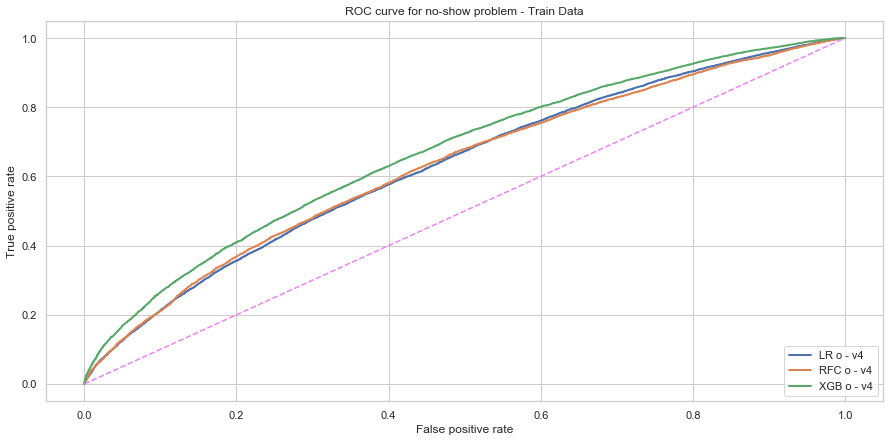

In [71]:
# Compare ROCs for:
fpr13, tpr13, thresholds13 = roc_curve(yv4_resampled, yv4_resampled_LR_o_prob) # LR
fpr14, tpr14, thresholds14 = roc_curve(yv4_resampled, yv4_resampled_RFC_o_prob) # RFC
fpr15, tpr15, thresholds15 = roc_curve(yv4_resampled, yv4_resampled_XGB_o_prob) # XGB
# fpr16, tpr16, thresholds16 = roc_curve(yv4_resampled, yv4_resampled_LGB_o_prob) # LGB


plt.figure(figsize=(15,7))

plt.plot(fpr13, tpr13,lw=2,label='LR o - v4')
plt.plot(fpr14, tpr14,lw=2,label='RFC o - v4')
plt.plot(fpr15, tpr15,lw=2,label='XGB o - v4')
# plt.plot(fpr16, tpr16,lw=2,label='LGB o - v4')

plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.legend(loc='lower right')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for no-show problem - Train Data');

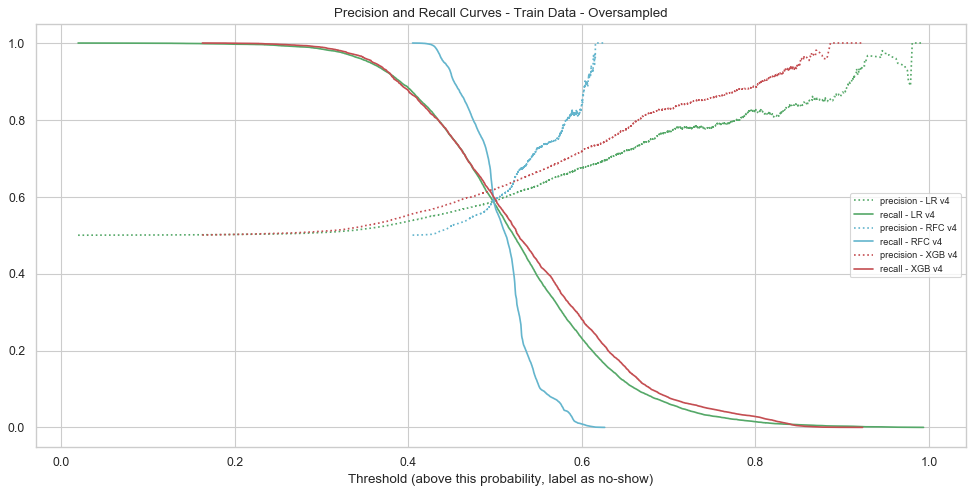

In [72]:
# Compare Precision/Recall curves
precision_curve2, recall_curve2, threshold_curve2 = precision_recall_curve(yv4_resampled, yv4_resampled_LR_o_prob)
precision_curve4, recall_curve4, threshold_curve4 = precision_recall_curve(yv4_resampled, yv4_resampled_RFC_o_prob)
precision_curve5, recall_curve5, threshold_curve5 = precision_recall_curve(yv4_resampled, yv4_resampled_XGB_o_prob)
# precision_curve6, recall_curve6, threshold_curve6 = precision_recall_curve(yv4_resampled, yv4_resampled_LGB_o_prob)

plt.figure(dpi=80,figsize=(15,7))
plt.plot(threshold_curve2, precision_curve2[1:],label='precision - LR v4',color='g',linestyle=':')
plt.plot(threshold_curve2, recall_curve2[1:], label='recall - LR v4',color='g')
plt.plot(threshold_curve4, precision_curve4[1:],label='precision - RFC v4',color='c',linestyle=':')
plt.plot(threshold_curve4, recall_curve4[1:], label='recall - RFC v4',color='c')
plt.plot(threshold_curve5, precision_curve5[1:],label='precision - XGB v4',color='r',linestyle=':')
plt.plot(threshold_curve5, recall_curve5[1:], label='recall - XGB v4',color='r')
# plt.plot(threshold_curve6, precision_curve6[1:],label='precision - XGB v4',color='purple',linestyle=':')
# plt.plot(threshold_curve6, recall_curve6[1:], label='recall - XGB v4',color='purple')
plt.legend(loc='center right',fontsize='small')
plt.xlabel('Threshold (above this probability, label as no-show)');
plt.title('Precision and Recall Curves - Train Data - Oversampled');

#### Test Data

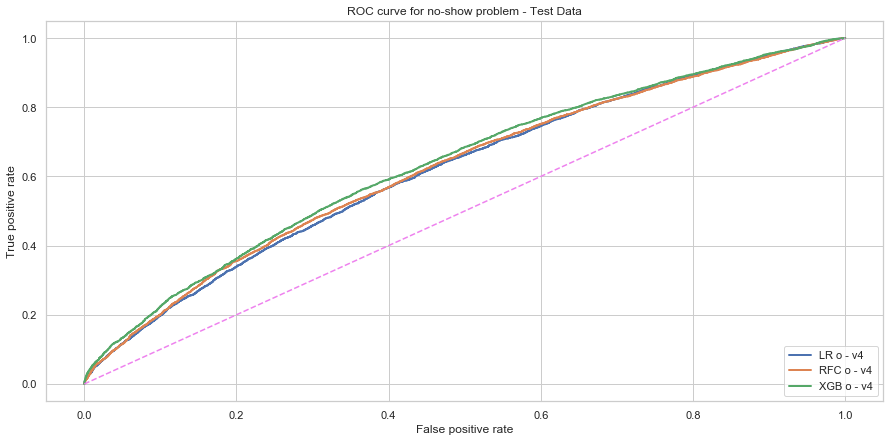

In [73]:
# Compare ROCs for:
fpr13, tpr13, thresholds13 = roc_curve(yv4_test, yv4_test_LR_o_prob) # LR
fpr14, tpr14, thresholds14 = roc_curve(yv4_test, yv4_test_RFC_o_prob) # RFC
fpr15, tpr15, thresholds15 = roc_curve(yv4_test, yv4_test_XGB_o_prob) # XGB
# fpr16, tpr16, thresholds16 = roc_curve(yv4_test, yv4_test_LGB_o_prob) # XGB


plt.figure(figsize=(15,7))

plt.plot(fpr13, tpr13,lw=2,label='LR o - v4')
plt.plot(fpr14, tpr14,lw=2,label='RFC o - v4')
plt.plot(fpr15, tpr15,lw=2,label='XGB o - v4')
# plt.plot(fpr16, tpr16,lw=2,label='LGB o - v4')

plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.legend(loc='lower right')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for no-show problem - Test Data');

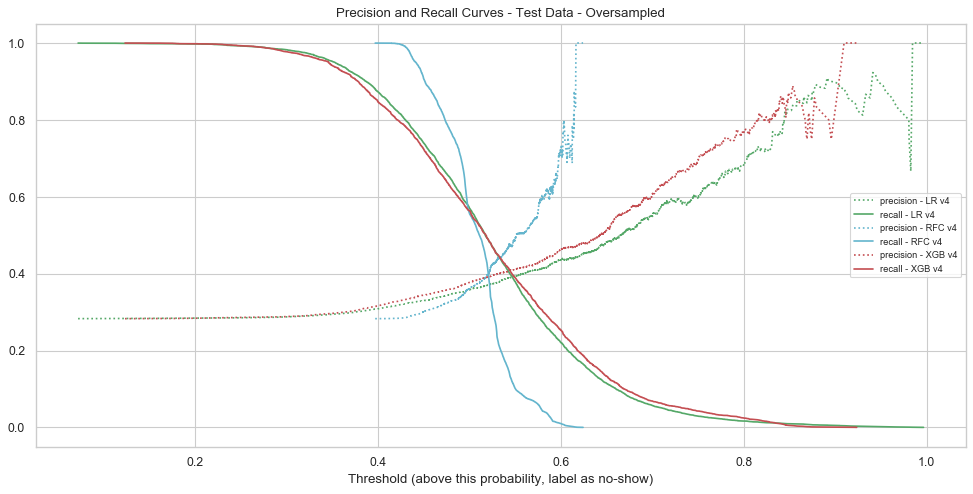

In [74]:
# Compare Precision/Recall curves
precision_curve2, recall_curve2, threshold_curve2 = precision_recall_curve(yv4_test, yv4_test_LR_o_prob)
precision_curve4, recall_curve4, threshold_curve4 = precision_recall_curve(yv4_test, yv4_test_RFC_o_prob)
precision_curve5, recall_curve5, threshold_curve5 = precision_recall_curve(yv4_test, yv4_test_XGB_o_prob)
# precision_curve6, recall_curve6, threshold_curve6 = precision_recall_curve(yv4_test, yv4_test_LGB_o_prob)

plt.figure(dpi=80,figsize=(15,7))
plt.plot(threshold_curve2, precision_curve2[1:],label='precision - LR v4',color='g',linestyle=':')
plt.plot(threshold_curve2, recall_curve2[1:], label='recall - LR v4',color='g')
plt.plot(threshold_curve4, precision_curve4[1:],label='precision - RFC v4',color='c',linestyle=':')
plt.plot(threshold_curve4, recall_curve4[1:], label='recall - RFC v4',color='c')
plt.plot(threshold_curve5, precision_curve5[1:],label='precision - XGB v4',color='r',linestyle=':')
plt.plot(threshold_curve5, recall_curve5[1:], label='recall - XGB v4',color='r')
# plt.plot(threshold_curve6, precision_curve6[1:],label='precision - LGB v4',color='purple',linestyle=':')
# plt.plot(threshold_curve6, recall_curve6[1:], label='recall - LGB v4',color='purple')
plt.legend(loc='center right',fontsize='small')
plt.xlabel('Threshold (above this probability, label as no-show)');
plt.title('Precision and Recall Curves - Test Data - Oversampled');

### Ensembling

In [ ]:
from mlxtend.classifier import StackingCVClassifier # <-- note: this is not from sklearn!

from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

In [ ]:
model_vars = [eval('LR'),eval('RFC'),eval('XGB')]

stacked = StackingCVClassifier(
    classifiers=model_vars, meta_classifier=LogisticRegression(), use_probas=False, n_jobs=-1)

stacked.fit(Xv4_train,yv4_train)

In [ ]:
yv4_train_pred = stacked.predict(Xv4_train.values)
yv4_train_pred_prob = stacked.predict_proba(Xv4_train.values)[:,1]

roc_auc_score(yv4_train,yv4_train_pred_prob)

In [ ]:
# using the new threshold
threshold = 0.4
y_predict = (XGB.predict_proba(Xv4_test)[:,1] > threshold)
print(f"Threshold of {threshold}:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(yv4_test, y_predict), 
                                                     recall_score(yv4_test, y_predict)))

In [64]:
#pickle models
with open("pickles/LR_model.pkl", "wb") as f:
    pickle.dump(LR, f)
with open("pickles/RFC_model.pkl", "wb") as f:
    pickle.dump(RFC, f)
with open("pickles/XGB_model.pkl", "wb") as f:
    pickle.dump(XGB, f)
with open("pickles/LGB_model.pkl", "wb") as f:
    pickle.dump(LGB, f)

In [9]:
with open('pickles/X_train.pickle', 'wb') as to_write:
    pickle.dump(Xv4_resampled, to_write)
with open('pickles/y_train.pickle', 'wb') as to_write:
    pickle.dump(yv4_resampled, to_write)
with open('pickles/X_test.pickle', 'wb') as to_write:
    pickle.dump(Xv4_test, to_write)
with open('pickles/y_test.pickle', 'wb') as to_write:
    pickle.dump(yv4_test, to_write)